<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
가중합을 통해 seasonal output과 Trend output의 비율을 정해주었다

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [47]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [48]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [49]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [50]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [51]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [52]:
tup= (1,2)
len(tup)

2

In [53]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [54]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [55]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        self.Linear_Sum = nn.Linear(2,1)
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
#         print(season_output.size(),trend_output.size())
        SUM_OUTPUT = self.Linear_Sum(torch.cat([season_output,trend_output],dim=2))
        output = (SUM_OUTPUT)*div_factor
        
        return output,season_output,trend_output

In [56]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [57]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [58]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [59]:
target

tensor([[[0.2092]],

        [[0.2202]],

        [[0.2011]],

        ...,

        [[0.1768]],

        [[0.1615]],

        [[0.1736]]], device='cuda:0')

In [60]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [61]:
torch.manual_seed(42)

In [62]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [63]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 14.226381414466434 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 13.318307673809123 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 13.307078202739794 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 22.047038592877442 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 13.927328466323385 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 12.193824604415058 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 11.20421886051956 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 10.720751328252213 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 10.418868784667454 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 10.478168871057662 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 10.797445176724802 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 10.690549667815716 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 10.63409947207448 %
A

In [64]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.43157739251114435 %
SMAPE 19.238064482808113 %
SMAPE 2.527179315686226 %
SMAPE 5.818731654435396 %
SMAPE 0.3132330105641472 %
SMAPE 0.6404170397659072 %
SMAPE 9.158157609403133 %
SMAPE 0.2545968939788281 %
SMAPE 0.7193515346680215 %
SMAPE 2.9872886557132006 %
SMAPE 0.019389155095041133 %
SMAPE 13.874065786600113 %
SMAPE 0.1210301889832408 %
SMAPE 5.685400798916817 %
SMAPE 7.3572289533913136 %
SMAPE 4.188663981854916 %
SMAPE 10.914933241903782 %
SMAPE 10.165338478982449 %
SMAPE 4.360562212765217 %
SMAPE 0.08324842634246465 %
SMAPE 4.1342561058700085 %
SMAPE 17.45863138139248 %
SMAPE 0.05293169397953079 %
SMAPE 0.7270061532353793 %
SMAPE 2.4796486673876643 %
SMAPE 10.7774154022336 %
SMAPE 4.832330763339996 %
SMAPE 3.074313297867775 %
SMAPE 0.0785137692207627 %
SMAPE 1.4907779500354081 %
SMAPE 0.1976927460703166 %
SMAPE 21.897227182984352 %
SMAPE 4.658308953046799 %
SMAPE 0.9514125163914287 %
SMAPE 1.8594665760174391 %
SMAPE 5.148421157151461 %
SMAPE 10.53316754847765 %
SMAPE 2.45

SMAPE 0.6469040476572445 %
SMAPE 0.3494804455206122 %
SMAPE 5.3568836487829685 %
SMAPE 0.7250596110425249 %
SMAPE 12.353978946805 %
SMAPE 0.27151060280831985 %
SMAPE 1.874942263122648 %
SMAPE 15.035604327917099 %
SMAPE 7.853382915258407 %
SMAPE 7.144509274512529 %
SMAPE 10.445752955973148 %
SMAPE 5.72815116494894 %
SMAPE 0.045117614548416896 %
SMAPE 2.1908861780539155 %
SMAPE 14.301288977265358 %
SMAPE 0.8079123939751298 %
SMAPE 2.5788085646927357 %
SMAPE 5.300651993602514 %
SMAPE 3.9046594072133303 %
SMAPE 8.80544189363718 %
SMAPE 5.142561718821526 %
SMAPE 9.081493325531483 %
SMAPE 5.248281016945839 %
SMAPE 3.6293641384691004 %
SMAPE 24.009111553430557 %
SMAPE 6.132633920758963 %
SMAPE 1.679664527066052 %
SMAPE 3.356957422569394 %
SMAPE 2.657143510878086 %
SMAPE 5.661936067044735 %
SMAPE 4.396610369905829 %
SMAPE 0.4821368901802998 %
SMAPE 2.6422435250133276 %
SMAPE 1.8210936193354428 %
SMAPE 14.561468228697777 %
SMAPE 0.6206632932480716 %
SMAPE 0.45848277090385636 %
SMAPE 10.52481102

SMAPE 7.464841954410076 %
SMAPE 9.109225399792194 %
SMAPE 0.5933564813785779 %
SMAPE 0.9711405039270175 %
SMAPE 0.06108071820108308 %
SMAPE 13.367365390062332 %
SMAPE 1.7271039572078735 %
SMAPE 4.703000295907259 %
SMAPE 1.6475087190046909 %
SMAPE 18.68187290430069 %
SMAPE 1.463050164282322 %
SMAPE 10.740806318819523 %
SMAPE 6.193668242543936 %
SMAPE 2.2277451334521174 %
SMAPE 4.147158866748214 %
SMAPE 20.281240612268448 %
SMAPE 7.8530399426817885 %
SMAPE 1.0316508777577837 %
SMAPE 6.505134578794242 %
SMAPE 14.745739862322807 %
SMAPE 7.04475551098585 %
SMAPE 0.03989829118484067 %
SMAPE 0.005564599944790416 %
SMAPE 4.968103896826506 %
SMAPE 4.1715711653232574 %
SMAPE 7.7056122943758965 %
SMAPE 3.4075264800339933 %
SMAPE 4.378626987338066 %
SMAPE 3.8285818342119455 %
SMAPE 13.835691452026367 %
SMAPE 7.508152790367603 %
SMAPE 7.366437871009111 %
SMAPE 0.40084288330945134 %
SMAPE 0.2093517899006656 %
SMAPE 0.0662963930622027 %
SMAPE 12.095055438578129 %
SMAPE 10.364359065890312 %
SMAPE 1.17

SMAPE 2.3819421753287315 %
SMAPE 15.201319247484207 %
SMAPE 0.6425999019575102 %
SMAPE 3.9601593092083927 %
SMAPE 2.142815938219428 %
SMAPE 0.43893015591129375 %
SMAPE 1.3592711834644433 %
SMAPE 12.312859043478966 %
SMAPE 1.9684314015321434 %
SMAPE 2.693306626752019 %
SMAPE 5.564163725823164 %
SMAPE 16.756022050976753 %
SMAPE 1.4281400189647684 %
SMAPE 10.304065138101578 %
SMAPE 0.013571640778366147 %
SMAPE 0.2608345953337903 %
SMAPE 2.489485116675496 %
SMAPE 7.8338978961110115 %
SMAPE 0.24094832180162484 %
SMAPE 1.802370741032064 %
SMAPE 2.1809726832434535 %
SMAPE 13.322736777365208 %
SMAPE 0.05223829348256003 %
SMAPE 0.6648755981805152 %
SMAPE 0.9671503787030815 %
SMAPE 2.281055140309036 %
SMAPE 1.6944226999767122 %
SMAPE 12.70558962225914 %
SMAPE 4.910276778042316 %
SMAPE 0.18903235365314686 %
SMAPE 2.9297374254092574 %
SMAPE 17.22113937139511 %
SMAPE 0.06378747682832397 %
SMAPE 11.684416644275188 %
SMAPE 4.375737579539418 %
SMAPE 3.777909368276596 %
SMAPE 3.76505290158093 %
SMAPE 1

SMAPE 11.089585810899734 %
SMAPE 0.048519539330754924 %
SMAPE 0.026343962723785808 %
SMAPE 5.288079604506493 %
SMAPE 11.876820743083954 %
SMAPE 0.33187994169611557 %
SMAPE 0.22505862898742637 %
SMAPE 0.05245818554385551 %
SMAPE 1.5194143384724157 %
SMAPE 4.04150003939867 %
SMAPE 6.693610277026892 %
SMAPE 1.261437099230534 %
SMAPE 0.6213238241054171 %
SMAPE 3.028493082150817 %
SMAPE 20.46684703230858 %
SMAPE 0.20198937869827205 %
SMAPE 4.137861389666796 %
SMAPE 0.9338127674582211 %
SMAPE 0.9153057185221769 %
SMAPE 5.690898418426514 %
SMAPE 5.302408557385206 %
SMAPE 1.0522642000814812 %
SMAPE 0.7660809731278277 %
SMAPE 0.8851910313051121 %
SMAPE 14.728487685322762 %
SMAPE 0.4173324985495128 %
SMAPE 2.4225691873580217 %
SMAPE 2.3070537196472287 %
SMAPE 1.0596837111261266 %
SMAPE 0.021495329985555145 %
SMAPE 17.8153083473444 %
SMAPE 7.167041212320329 %
SMAPE 0.13836333554627345 %
SMAPE 4.212841792032123 %
SMAPE 12.874017909169197 %
SMAPE 5.760493751615286 %
SMAPE 0.20525664634305937 %
SMAP

SMAPE 1.0321325349605104 %
SMAPE 0.09073888097697136 %
SMAPE 0.22830459367264663 %
SMAPE 11.728874176740646 %
SMAPE 4.578026250004768 %
SMAPE 1.402342889457941 %
SMAPE 0.11986237798510048 %
SMAPE 5.536347530782223 %
SMAPE 10.56841640919447 %
SMAPE 1.127494862084859 %
SMAPE 3.8581600580364466 %
SMAPE 0.02756731204178209 %
SMAPE 0.262460211844882 %
SMAPE 2.3468130584806204 %
SMAPE 8.464582934975624 %
SMAPE 0.6043533417951039 %
SMAPE 0.5725668371960637 %
SMAPE 2.427269024774432 %
SMAPE 13.103898346424103 %
SMAPE 0.04983099184045159 %
SMAPE 1.5049401486758143 %
SMAPE 1.826540081994608 %
SMAPE 0.10500792683797044 %
SMAPE 1.208023696744931 %
SMAPE 22.644007369875908 %
SMAPE 8.320274271070957 %
SMAPE 0.020613096813576703 %
SMAPE 1.1949033835771843 %
SMAPE 9.32925297319889 %
SMAPE 6.7227174043655396 %
SMAPE 0.30727055948308646 %
SMAPE 0.06856485393166167 %
SMAPE 2.290672773960978 %
SMAPE 5.934147767722607 %
SMAPE 4.211196171119809 %
SMAPE 0.08242096130101118 %
SMAPE 2.080692375646322 %
SMAPE 1

SMAPE 0.1789865164373623 %
SMAPE 3.939902152866125 %
SMAPE 0.8797455401338538 %
SMAPE 0.1895476449144553 %
SMAPE 11.627730794250965 %
SMAPE 3.0649358360096812 %
SMAPE 7.443183429539204 %
SMAPE 5.304227840155363 %
SMAPE 1.1654556710927864 %
SMAPE 9.88846179842949 %
SMAPE 2.5424490915611386 %
SMAPE 2.6799758076667786 %
SMAPE 0.01924115199113885 %
SMAPE 5.151901096105576 %
SMAPE 1.0501887259742944 %
SMAPE 25.970677673816684 %
SMAPE 14.146123588085175 %
SMAPE 10.571216523647308 %
SMAPE 4.661092756316066 %
SMAPE 9.932418517768383 %
SMAPE 3.2433532392606135 %
SMAPE 9.206837967038155 %
SMAPE 1.2296060812223004 %
SMAPE 3.1061568399891257 %
SMAPE 9.749825783073902 %
SMAPE 5.012523669749498 %
SMAPE 0.9300744048196065 %
SMAPE 0.02501018307361846 %
SMAPE 12.80312218517065 %
SMAPE 4.40432414226234 %
SMAPE 2.4335038689896464 %
SMAPE 0.4992381647371076 %
SMAPE 1.7426875804085287 %
SMAPE 1.6590391063728018 %
SMAPE 6.0909463204443455 %
SMAPE 5.583931293338537 %
SMAPE 1.5682313638753842 %
SMAPE 2.727630

SMAPE 10.846439495682716 %
SMAPE 0.6417888708815553 %
SMAPE 3.729854341596365 %
SMAPE 3.3808540292084217 %
SMAPE 0.19307029163871903 %
SMAPE 3.477943383484671 %
SMAPE 7.615669723600149 %
SMAPE 4.410618204623461 %
SMAPE 0.9197343966952758 %
SMAPE 3.913551859557628 %
SMAPE 3.7154150307178493 %
SMAPE 5.51252131536603 %
SMAPE 1.1999175191231188 %
SMAPE 0.11336220253235751 %
SMAPE 0.4582678900242172 %
SMAPE 4.102641030214727 %
SMAPE 6.245595069602132 %
SMAPE 0.6276230421103719 %
SMAPE 0.39815339674623823 %
SMAPE 9.576596021652222 %
SMAPE 1.0011782382207457 %
SMAPE 5.60190012678504 %
SMAPE 0.0445267006426775 %
SMAPE 0.24516164253964237 %
SMAPE 7.928011119365692 %
SMAPE 6.166002130135894 %
SMAPE 4.889032911509275 %
SMAPE 0.5262626592557353 %
SMAPE 0.3103990577218667 %
SMAPE 0.20462338771159239 %
SMAPE 7.635323300957681 %
SMAPE 3.570587009191513 %
SMAPE 4.97025340795517 %
SMAPE 1.9979071614943678 %
SMAPE 1.7549349373221046 %
SMAPE 3.5604291721247137 %
SMAPE 10.870307259261608 %
SMAPE 1.1363619

SMAPE 14.564052231609823 %
SMAPE 5.579379115253687 %
SMAPE 0.20761086455127042 %
SMAPE 0.6163431118627614 %
SMAPE 5.627474248409271 %
SMAPE 0.6001597115941877 %
SMAPE 2.2910764971747994 %
SMAPE 0.2899357287029858 %
SMAPE 1.5250596050591412 %
SMAPE 3.4811973506584764 %
SMAPE 0.929948836539552 %
SMAPE 8.948666520416737 %
SMAPE 1.7827554735777085 %
SMAPE 4.4366791769862175 %
SMAPE 7.107213031500578 %
SMAPE 0.32611469375069646 %
SMAPE 4.438511598855257 %
SMAPE 3.7892596293240786 %
SMAPE 9.824286244809628 %
SMAPE 5.552771802991629 %
SMAPE 5.338076543062925 %
SMAPE 1.1715723465570136 %
SMAPE 0.05211867967477702 %
SMAPE 2.013921004254371 %
SMAPE 6.5367264710366735 %
SMAPE 0.017696650303548722 %
SMAPE 1.9016225554514674 %
SMAPE 0.4947694589509411 %
SMAPE 5.140245024114847 %
SMAPE 4.457489687448287 %
SMAPE 8.560199916362762 %
SMAPE 0.744629809534672 %
SMAPE 0.052822285117564156 %
SMAPE 8.890519320964813 %
SMAPE 1.063640564938396 %
SMAPE 0.2530640686911738 %
SMAPE 0.621452659885108 %
SMAPE 0.345

SMAPE 4.277064291760325 %
SMAPE 0.04738702114829607 %
SMAPE 7.98180278763175 %
SMAPE 2.102173787990978 %
SMAPE 0.14595725327012588 %
SMAPE 0.024022819331548817 %
SMAPE 0.1612081321968617 %
SMAPE 4.504261404275894 %
SMAPE 0.6724555150867673 %
SMAPE 2.3189357640221715 %
SMAPE 4.646919006481767 %
SMAPE 0.11440760079062784 %
SMAPE 0.34619107066100696 %
SMAPE 3.275813762098551 %
SMAPE 0.9208823339431547 %
SMAPE 1.7198047129932095 %
SMAPE 0.05201160185845311 %
SMAPE 9.583497904241085 %
SMAPE 0.07753610726854276 %
SMAPE 0.32715442010794504 %
SMAPE 0.01735097560151644 %
SMAPE 4.191776426509023 %
SMAPE 1.1469976337334629 %
SMAPE 14.00809282064438 %
SMAPE 0.44769381011258247 %
SMAPE 0.09018120530264184 %
SMAPE 1.210070093133254 %
SMAPE 1.8241838747635484 %
SMAPE 1.743954312754795 %
SMAPE 0.8480491517202609 %
SMAPE 1.1936508705584856 %
SMAPE 0.728046815165726 %
SMAPE 6.398985266685486 %
SMAPE 1.1004920110772218 %
SMAPE 1.2454415554302614 %
SMAPE 0.7201734090349419 %
SMAPE 6.4586727917194375 %
SMA

SMAPE 1.0608195750519371 %
SMAPE 7.161450311541557 %
SMAPE 8.43303232640028 %
SMAPE 12.222095631062984 %
SMAPE 9.467060677707195 %
SMAPE 1.004024387231766 %
SMAPE 6.032319031655788 %
SMAPE 2.9927920431800885 %
SMAPE 3.791787890717387 %
SMAPE 4.22485725954175 %
SMAPE 9.667333364486694 %
SMAPE 0.7754147417253989 %
SMAPE 5.157090362161398 %
SMAPE 0.5837634821164102 %
SMAPE 0.17219396583552538 %
SMAPE 0.8294878207252623 %
SMAPE 3.569525664672255 %
SMAPE 14.934443444013596 %
SMAPE 7.18123996630311 %
SMAPE 1.5065403692569816 %
SMAPE 0.17407351859583287 %
SMAPE 9.185599848628044 %
SMAPE 3.2125331275165077 %
SMAPE 4.687589069828391 %
SMAPE 0.5515764410129123 %
SMAPE 0.11227733815726992 %
SMAPE 0.6901062882984661 %
SMAPE 4.356765811651712 %
SMAPE 5.418373806402087 %
SMAPE 4.016817349940538 %
SMAPE 1.840183949097991 %
SMAPE 1.5655624095234089 %
SMAPE 2.4817801509052515 %
SMAPE 2.3442454328760505 %
SMAPE 0.03159307700889258 %
SMAPE 0.6423512754445255 %
SMAPE 10.248406492173672 %
SMAPE 0.154172253

SMAPE 0.08386221272485272 %
SMAPE 5.145027153193951 %
SMAPE 3.7389093359815893 %
SMAPE 1.773924570195959 %
SMAPE 4.925038747489452 %
SMAPE 0.37907372180143284 %
SMAPE 0.05732161022541504 %
SMAPE 0.5665370434962824 %
SMAPE 1.777417983947089 %
SMAPE 5.413320271298289 %
SMAPE 11.573056444525719 %
SMAPE 0.5033332497259835 %
SMAPE 3.027731428388506 %
SMAPE 0.03682162679211842 %
SMAPE 4.754744987934828 %
SMAPE 0.6191830630300501 %
SMAPE 3.468169281259179 %
SMAPE 0.2944993429537135 %
SMAPE 0.5368682954272117 %
SMAPE 0.1310140452176256 %
SMAPE 1.3907258368672046 %
SMAPE 0.9025020448516443 %
SMAPE 2.5017041218234226 %
SMAPE 13.904292546212673 %
SMAPE 7.086112976074219 %
SMAPE 5.6339795254170895 %
SMAPE 0.14465543254527802 %
SMAPE 0.07127166570467125 %
SMAPE 0.12245807602835157 %
SMAPE 4.253009515228541 %
SMAPE 0.13287395209741248 %
SMAPE 2.2513985912373755 %
SMAPE 0.1234763493295077 %
SMAPE 1.6031733509153128 %
SMAPE 3.2428011316806082 %
SMAPE 1.1391890159557079 %
SMAPE 5.3699259124696255 %
SMA

SMAPE 0.4674852015086799 %
SMAPE 5.6900157034397125 %
SMAPE 1.2529355483602558 %
SMAPE 6.84835160523653 %
SMAPE 1.4538677388991346 %
SMAPE 2.346126361639108 %
SMAPE 0.8470991050671728 %
SMAPE 0.03796605040997747 %
SMAPE 1.6264325662050396 %
SMAPE 2.5439667711034417 %
SMAPE 0.16559006654529185 %
SMAPE 0.01850772321459715 %
SMAPE 0.013372259338780166 %
SMAPE 1.943644899249193 %
SMAPE 8.662984278053045 %
SMAPE 1.1632060669990096 %
SMAPE 0.14040424713800803 %
SMAPE 0.18971041761074048 %
SMAPE 2.55407587159425 %
SMAPE 3.4818789828568697 %
SMAPE 0.2347490010501474 %
SMAPE 0.2277504178309755 %
SMAPE 0.17686664588552503 %
SMAPE 4.717986207455397 %
SMAPE 6.920207928866148 %
SMAPE 0.03723203710978851 %
SMAPE 4.390695657064498 %
SMAPE 12.233605101704597 %
SMAPE 9.818972993642092 %
SMAPE 0.4636651881819489 %
SMAPE 2.745899446308613 %
SMAPE 3.5479323919862504 %
SMAPE 2.858289795462042 %
SMAPE 6.331048171967268 %
SMAPE 0.03617163640103627 %
SMAPE 4.111547755077481 %
SMAPE 2.9441694285778794 %
SMAPE 

SMAPE 14.389191962778568 %
SMAPE 0.35039492255236837 %
SMAPE 3.303625370172085 %
SMAPE 4.33336977660656 %
SMAPE 0.18680215674294232 %
SMAPE 1.9928103764541447 %
SMAPE 3.2030884912237525 %
SMAPE 4.350526126101613 %
SMAPE 1.1793411473572633 %
SMAPE 4.068370564375073 %
SMAPE 1.2521360305672715 %
SMAPE 3.2463418388215355 %
SMAPE 2.0981285059560832 %
SMAPE 1.1289754182162142 %
SMAPE 2.2672347631305456 %
SMAPE 1.0189445530741068 %
SMAPE 1.1793295168245095 %
SMAPE 0.31597075166041577 %
SMAPE 0.10103130597758536 %
SMAPE 3.452511131821666 %
SMAPE 1.0066827582177211 %
SMAPE 1.998518097694614 %
SMAPE 1.167562276089484 %
SMAPE 0.013931510592897213 %
SMAPE 1.7479776034597307 %
SMAPE 3.165353901684284 %
SMAPE 2.8967631300911307 %
SMAPE 0.1469212605506982 %
SMAPE 1.6200883370656811 %
SMAPE 0.485298786272324 %
SMAPE 9.519848600029945 %
SMAPE 3.8040644424036145 %
SMAPE 2.6037582913668302 %
SMAPE 3.156601294875145 %
SMAPE 6.911192011088133 %
SMAPE 0.2705915598600086 %
SMAPE 0.026568918884436247 %
SMAPE 

SMAPE 0.9948041503157583 %
SMAPE 6.057652298361063 %
SMAPE 4.852449141442776 %
SMAPE 0.4154873371460326 %
SMAPE 0.4864649931814711 %
SMAPE 12.077088177204132 %
SMAPE 9.601226136088371 %
SMAPE 9.186196688562632 %
SMAPE 15.250682607293129 %
SMAPE 6.088213376700878 %
SMAPE 8.577668093144894 %
SMAPE 1.6169976070523264 %
SMAPE 7.774650909006596 %
SMAPE 5.4412940591573715 %
SMAPE 0.6433966572367353 %
SMAPE 18.83747686445713 %
SMAPE 10.459395930171013 %
SMAPE 11.57681705057621 %
SMAPE 14.985416233539581 %
SMAPE 1.3115805402412661 %
SMAPE 10.284013465046883 %
SMAPE 2.463020073249936 %
SMAPE 8.385249570012093 %
SMAPE 6.757937826216221 %
SMAPE 0.15275212950922423 %
SMAPE 31.301882922649384 %
SMAPE 26.38056805729866 %
SMAPE 0.8739859375273227 %
SMAPE 9.14304593205452 %
SMAPE 2.054528595879674 %
SMAPE 4.017614543437958 %
SMAPE 1.2076298985339236 %
SMAPE 6.0066354386508465 %
SMAPE 3.612701455131173 %
SMAPE 0.23845815061713438 %
SMAPE 12.276469834148884 %
SMAPE 0.34383467455381833 %
SMAPE 11.8867525

SMAPE 18.09485912322998 %
SMAPE 12.792699672281744 %
SMAPE 4.504451913759112 %
SMAPE 12.68042827397585 %
SMAPE 3.5247804746031757 %
SMAPE 0.25590897271513313 %
SMAPE 0.14679250964741186 %
SMAPE 2.295536745339632 %
SMAPE 18.135929465293884 %
SMAPE 9.376620513561647 %
SMAPE 8.052201613783836 %
SMAPE 10.496617294847965 %
SMAPE 5.020330360159278 %
SMAPE 14.528353363275528 %
SMAPE 0.7800802899801056 %
SMAPE 1.2146888098068302 %
SMAPE 0.2051393789975009 %
SMAPE 0.3690274036284791 %
SMAPE 25.927748262882233 %
SMAPE 6.2278500981628895 %
SMAPE 2.2350256925715257 %
SMAPE 5.157119583338499 %
SMAPE 7.326307062059641 %
SMAPE 2.2243918338790536 %
SMAPE 5.816949263215065 %
SMAPE 6.732322935014963 %
SMAPE 3.415390992537141 %
SMAPE 2.353801742196083 %
SMAPE 16.757257416844368 %
SMAPE 10.09112960845232 %
SMAPE 2.250438425147877 %
SMAPE 17.437636628746986 %
SMAPE 8.601215980947018 %
SMAPE 11.762883447110653 %
SMAPE 11.914845421910286 %
SMAPE 2.8450907384976745 %
SMAPE 1.207323343725875 %
SMAPE 12.1381416

SMAPE 1.3649302200356033 %
SMAPE 2.2921442131046206 %
SMAPE 5.233642182545736 %
SMAPE 1.0843715339733535 %
SMAPE 0.5571445825307819 %
SMAPE 5.758517399430275 %
SMAPE 6.172987557947636 %
SMAPE 4.647743385285139 %
SMAPE 4.93119877949357 %
SMAPE 0.3396419336755798 %
SMAPE 1.766007788319257 %
SMAPE 5.50462638027966 %
SMAPE 9.863073352724314 %
SMAPE 2.006951189501706 %
SMAPE 0.44820152528336615 %
SMAPE 3.111979492008686 %
SMAPE 6.968047060072421 %
SMAPE 1.6432233445812017 %
SMAPE 2.013543626278988 %
SMAPE 0.7552716168199822 %
SMAPE 1.116499867708626 %
SMAPE 6.711202358826995 %
SMAPE 1.167770488579663 %
SMAPE 2.028996289955103 %
SMAPE 2.449014727360918 %
SMAPE 2.481053509749472 %
SMAPE 3.0109640983864665 %
SMAPE 7.988061860203743 %
SMAPE 0.9801675352937309 %
SMAPE 3.8983849631622434 %
SMAPE 1.8644424803424047 %
SMAPE 0.6204780627922446 %
SMAPE 1.7715540031204 %
SMAPE 1.3876218781188072 %
SMAPE 1.3841076849785168 %
SMAPE 0.6749451374926139 %
SMAPE 0.34682246166210007 %
SMAPE 4.003589991480112

SMAPE 1.1724483494253946 %
SMAPE 8.17363878339529 %
SMAPE 2.867082403972745 %
SMAPE 1.5399203413981013 %
SMAPE 0.025928106279252457 %
SMAPE 0.023109251004143516 %
SMAPE 2.9729226597041816 %
SMAPE 8.485731236636639 %
SMAPE 5.5361491441726685 %
SMAPE 0.526758705696011 %
SMAPE 0.6939932247441902 %
SMAPE 10.745248384773731 %
SMAPE 0.809632330383465 %
SMAPE 6.098912242799997 %
SMAPE 0.9231765604708927 %
SMAPE 0.22757634825575224 %
SMAPE 2.5647216918878257 %
SMAPE 0.9975517247917197 %
SMAPE 1.1177073466751608 %
SMAPE 2.4733918868223554 %
SMAPE 0.7454180084055224 %
SMAPE 2.390770928468555 %
SMAPE 9.476073689758778 %
SMAPE 5.633819058537483 %
SMAPE 2.2754518046349403 %
SMAPE 0.09059239223006443 %
SMAPE 1.971098178299144 %
SMAPE 1.3978133736600284 %
SMAPE 0.1360848152780818 %
SMAPE 0.38340719310508575 %
SMAPE 2.046510898933775 %
SMAPE 0.276367587857294 %
SMAPE 7.781521949917078 %
SMAPE 0.09888920318964269 %
SMAPE 1.3683110955262237 %
SMAPE 0.19446764787426218 %
SMAPE 4.755952340085059 %
SMAPE 1

SMAPE 19.93364880979061 %
SMAPE 8.84549441706622 %
SMAPE 1.9074141837900243 %
SMAPE 2.5939781609922647 %
SMAPE 11.131149545311928 %
SMAPE 8.309067502617836 %
SMAPE 13.8623383641243 %
SMAPE 7.256933160126209 %
SMAPE 0.17817119566223028 %
SMAPE 9.1586599573493 %
SMAPE 0.04899655565293415 %
SMAPE 0.46107245672146746 %
SMAPE 1.121038446147395 %
SMAPE 2.060574262521186 %
SMAPE 0.9273159571403085 %
SMAPE 8.511788666248322 %
SMAPE 0.18774526138076908 %
SMAPE 1.8794814560606028 %
SMAPE 0.8167859346267505 %
SMAPE 0.6556446806125678 %
SMAPE 0.25622106719492876 %
SMAPE 0.34784944796410855 %
SMAPE 0.3204887887161476 %
SMAPE 0.6863909419880656 %
SMAPE 1.9148969443049284 %
SMAPE 7.795942265540362 %
SMAPE 0.42004371029156573 %
SMAPE 0.7627922581887105 %
SMAPE 1.4094553364629974 %
SMAPE 4.142592846823391 %
SMAPE 5.249206051230431 %
SMAPE 0.14055408126773727 %
SMAPE 2.983883843458898 %
SMAPE 2.4130117537424667 %
SMAPE 4.57804486900568 %
SMAPE 4.2999825943261385 %
SMAPE 0.33272636154447355 %
SMAPE 0.227

SMAPE 0.3291851593512547 %
SMAPE 4.579673236235976 %
SMAPE 1.3688911724675563 %
SMAPE 1.0262858059513746 %
SMAPE 2.7759691355749965 %
SMAPE 3.491686153342016 %
SMAPE 0.46367797114999115 %
SMAPE 0.07994072779365524 %
SMAPE 2.0736407774165855 %
SMAPE 4.539018373936415 %
SMAPE 5.100104998797178 %
SMAPE 6.554540666053072 %
SMAPE 9.228231705725193 %
SMAPE 3.850970095023513 %
SMAPE 1.1071825089093181 %
SMAPE 1.6226828012913757 %
SMAPE 4.313689770497149 %
SMAPE 3.9263105772261038 %
SMAPE 5.473446035757661 %
SMAPE 0.23947297506424547 %
SMAPE 15.142038211226463 %
SMAPE 0.2615789503652195 %
SMAPE 0.027370979764441472 %
SMAPE 0.9948793687235592 %
SMAPE 4.467381194233894 %
SMAPE 23.51650834083557 %
SMAPE 2.7031069052318344 %
SMAPE 11.103268556296825 %
SMAPE 2.955691132694483 %
SMAPE 9.186770908534527 %
SMAPE 8.864424616098404 %
SMAPE 1.1227353324284195 %
SMAPE 5.726553238928318 %
SMAPE 2.813903871923685 %
SMAPE 1.5523194828865599 %
SMAPE 4.284115467220545 %
SMAPE 0.1769482326094476 %
SMAPE 5.28090

SMAPE 8.107550077140331 %
SMAPE 18.623343840241432 %
SMAPE 3.139490121975541 %
SMAPE 0.024731751970648475 %
SMAPE 2.851622948423028 %
SMAPE 4.1367541048675776 %
SMAPE 7.243944562971592 %
SMAPE 3.893089003860951 %
SMAPE 0.933750225057338 %
SMAPE 5.3618806861341 %
SMAPE 8.40936954319477 %
SMAPE 5.775171805173159 %
SMAPE 14.138314977288246 %
SMAPE 7.003728099167347 %
SMAPE 2.715021815150976 %
SMAPE 1.4911697955612908 %
SMAPE 1.2231634783602203 %
SMAPE 11.139329761266708 %
SMAPE 0.4170465016486559 %
SMAPE 4.05234768918308 %
SMAPE 0.14121171806095845 %
SMAPE 16.67114718258381 %
SMAPE 0.4007868305182001 %
SMAPE 7.603791084140539 %
SMAPE 0.3471305678824592 %
SMAPE 4.497304992750287 %
SMAPE 11.538292430341244 %
SMAPE 0.43477676896691264 %
SMAPE 2.0709228212945163 %
SMAPE 0.10398947778230651 %
SMAPE 24.62218241393566 %
SMAPE 1.2291404944917304 %
SMAPE 11.439550630748272 %
SMAPE 0.49245520601306225 %
SMAPE 0.4549531597367604 %
SMAPE 3.538864139467478 %
SMAPE 1.0687658793103765 %
SMAPE 1.50749626

SMAPE 0.9830044393493155 %
SMAPE 5.186505821053288 %
SMAPE 13.44242749363184 %
SMAPE 7.8617983646690845 %
SMAPE 4.835762418806553 %
SMAPE 6.365883890539408 %
SMAPE 13.594352394342424 %
SMAPE 10.193272285163403 %
SMAPE 5.307820484042168 %
SMAPE 0.7744964861237804 %
SMAPE 4.419202741235495 %
SMAPE 0.475792222423479 %
SMAPE 7.038647588342428 %
SMAPE 1.2744839825318195 %
SMAPE 12.88434412330389 %
SMAPE 2.2362775731153306 %
SMAPE 2.8585450649261475 %
SMAPE 0.13727842944126678 %
SMAPE 0.8319813753385006 %
SMAPE 1.5077284955568757 %
SMAPE 6.210447885096073 %
SMAPE 0.485910959310786 %
SMAPE 3.0927737141028047 %
SMAPE 8.104097202420235 %
SMAPE 7.291240692138672 %
SMAPE 0.8741573648903797 %
SMAPE 0.10753736146432404 %
SMAPE 0.012246640675584786 %
SMAPE 3.7839632797986273 %
SMAPE 2.3389191105343343 %
SMAPE 5.684081643819809 %
SMAPE 5.8328804494813085 %
SMAPE 4.064471954203327 %
SMAPE 12.834513239562511 %
SMAPE 1.6268329717568122 %
SMAPE 10.64217984676361 %
SMAPE 7.965564005076884 %
SMAPE 6.964535

SMAPE 1.2505573628968705 %
SMAPE 0.8159542804992269 %
SMAPE 14.432023972272873 %
SMAPE 0.09824069207371622 %
SMAPE 5.075037832051748 %
SMAPE 3.302970974797063 %
SMAPE 3.9664131778172305 %
SMAPE 9.551966696977615 %
SMAPE 0.8721302997637395 %
SMAPE 3.6394033075775956 %
SMAPE 1.836205337269348 %
SMAPE 0.44811428554021404 %
SMAPE 12.41795688867569 %
SMAPE 0.06880851088567397 %
SMAPE 6.808826003223658 %
SMAPE 2.675593750031112 %
SMAPE 0.8801352385562495 %
SMAPE 8.14314889907837 %
SMAPE 5.495654601603746 %
SMAPE 9.685649931430817 %
SMAPE 0.9482718432955152 %
SMAPE 0.5499754448572958 %
SMAPE 5.661478603142314 %
SMAPE 0.25655168241542015 %
SMAPE 1.560369545129106 %
SMAPE 3.301349409637624 %
SMAPE 1.116921192384325 %
SMAPE 8.940016396343708 %
SMAPE 3.029512381181121 %
SMAPE 3.136089214410731 %
SMAPE 3.4262898382730786 %
SMAPE 0.027026293888638975 %
SMAPE 6.531037632375955 %
SMAPE 6.565055958926677 %
SMAPE 2.7913507689954713 %
SMAPE 1.9114670166018186 %
SMAPE 0.651534479122347 %
SMAPE 14.8458775

SMAPE 12.614562682807446 %
SMAPE 1.7748633464798331 %
SMAPE 1.5358520484587643 %
SMAPE 4.129324993118644 %
SMAPE 2.260546846780926 %
SMAPE 0.16676140916183613 %
SMAPE 12.78537729009986 %
SMAPE 7.980415105819702 %
SMAPE 0.7009310402236224 %
SMAPE 0.9340007738412623 %
SMAPE 0.2684880866781896 %
SMAPE 12.792195498943329 %
SMAPE 4.947920216247439 %
SMAPE 2.190562161616981 %
SMAPE 0.07736613051747554 %
SMAPE 0.33069009476685096 %
SMAPE 0.6676645438101332 %
SMAPE 0.13289544168037537 %
SMAPE 2.1061900866188807 %
SMAPE 0.12620019624046108 %
SMAPE 3.9840423241257668 %
SMAPE 3.8597639501094823 %
SMAPE 3.1312930269341446 %
SMAPE 0.7015336552312874 %
SMAPE 0.22610756721428513 %
SMAPE 1.2614670433122228 %
SMAPE 4.993169251829386 %
SMAPE 1.0201872166212524 %
SMAPE 1.2781306899269111 %
SMAPE 0.5171240632953413 %
SMAPE 12.364303357899189 %
SMAPE 2.1826627224895674 %
SMAPE 1.6702710111394479 %
SMAPE 0.6043804987034491 %
SMAPE 5.205447173642824 %
SMAPE 6.283712405711412 %
SMAPE 0.19594621833766723 %
SMA

SMAPE 1.456251368697849 %
SMAPE 3.0562780324471532 %
SMAPE 4.962056063115597 %
SMAPE 10.785368598997593 %
SMAPE 4.914898734539747 %
SMAPE 0.4262979425438971 %
SMAPE 2.050709426868707 %
SMAPE 0.8228872511208465 %
SMAPE 8.550196036696434 %
SMAPE 0.04923386509608463 %
SMAPE 7.676488541066647 %
SMAPE 0.24497130641066175 %
SMAPE 7.120405945926906 %
SMAPE 7.143685199320317 %
SMAPE 8.348147258162498 %
SMAPE 0.720593440978746 %
SMAPE 1.1863013328402303 %
SMAPE 0.5530017756341294 %
SMAPE 0.6329374360968814 %
SMAPE 13.60059005767107 %
SMAPE 2.75741816939626 %
SMAPE 0.4362102876091285 %
SMAPE 12.319715884514153 %
SMAPE 18.27002465724945 %
SMAPE 0.356114847812421 %
SMAPE 9.364943496882915 %
SMAPE 2.1487409020774066 %
SMAPE 1.60930982301943 %
SMAPE 3.0872631520032883 %
SMAPE 0.5367840639702308 %
SMAPE 0.004354205038822556 %
SMAPE 0.1895980765659715 %
SMAPE 17.178250163793564 %
SMAPE 8.310836344957352 %
SMAPE 11.081088289618492 %
SMAPE 2.0858093318529427 %
SMAPE 1.5036385626881383 %
SMAPE 8.16796159

SMAPE 0.5776539174366917 %
SMAPE 0.677855844336591 %
SMAPE 0.12993744709285693 %
SMAPE 1.1866037311483524 %
SMAPE 21.606465369462967 %
SMAPE 9.795895528048277 %
SMAPE 4.303037894889712 %
SMAPE 6.713326111435889 %
SMAPE 0.12247509930045908 %
SMAPE 1.162488253612537 %
SMAPE 6.611512880772352 %
SMAPE 3.296133406460285 %
SMAPE 0.027316084704580135 %
SMAPE 0.21012342471703963 %
SMAPE 13.931321904063223 %
SMAPE 16.21100924909115 %
SMAPE 0.20727275648476962 %
SMAPE 9.861644238233566 %
SMAPE 0.24448366888782402 %
SMAPE 0.4723487279497931 %
SMAPE 4.5536961909383535 %
SMAPE 8.213202230632305 %
SMAPE 7.944807976484299 %
SMAPE 0.12139962154992645 %
SMAPE 3.9668052010238175 %
SMAPE 6.291430599987508 %
SMAPE 7.070787552744149 %
SMAPE 0.35655776775456616 %
SMAPE 2.0070342203835025 %
SMAPE 5.931000839918852 %
SMAPE 3.525687787681818 %
SMAPE 1.0964216264674178 %
SMAPE 0.23252437336759613 %
SMAPE 3.1059451540349983 %
SMAPE 1.5976735101285156 %
SMAPE 1.0891438447961264 %
SMAPE 10.354362629354 %
SMAPE 0.0

SMAPE 3.748744364944287 %
SMAPE 0.908218325487269 %
SMAPE 1.508770271881076 %
SMAPE 0.015539325356897393 %
SMAPE 4.932925896719098 %
SMAPE 7.436821226030588 %
SMAPE 1.1526520462666667 %
SMAPE 1.4775136738899164 %
SMAPE 4.842780100181699 %
SMAPE 0.053955296077560895 %
SMAPE 11.63183368742466 %
SMAPE 1.5967231004106 %
SMAPE 0.2738663024453558 %
SMAPE 8.230241119861603 %
SMAPE 0.8212373561147502 %
SMAPE 0.7914210316566823 %
SMAPE 3.9927411054190993 %
SMAPE 6.391968337971774 %
SMAPE 10.942151486873627 %
SMAPE 2.2233826480805874 %
SMAPE 1.3813955228069972 %
SMAPE 11.596166647970676 %
SMAPE 6.582506701350212 %
SMAPE 2.4500168312806636 %
SMAPE 0.7073537758889188 %
SMAPE 2.3273471305146813 %
SMAPE 3.2203510311519494 %
SMAPE 2.8154779780234094 %
SMAPE 4.006916647776961 %
SMAPE 6.654378287494183 %
SMAPE 0.35113171009470534 %
SMAPE 0.9262744574225508 %
SMAPE 0.22485174495091084 %
SMAPE 0.7488483909346542 %
SMAPE 1.4163454496156191 %
SMAPE 0.6447253006754181 %
SMAPE 2.7198935923952376 %
SMAPE 5.31

SMAPE 0.12558996661232413 %
SMAPE 7.771826080977917 %
SMAPE 10.500119872391224 %
SMAPE 2.7895430168136954 %
SMAPE 3.7109167892485853 %
SMAPE 1.0469984351004769 %
SMAPE 2.62910920381546 %
SMAPE 0.47443333628871187 %
SMAPE 3.537501879967749 %
SMAPE 1.9553247997537258 %
SMAPE 1.817277431498951 %
SMAPE 4.841911906507448 %
SMAPE 1.405260586165241 %
SMAPE 15.92272113263607 %
SMAPE 12.649439238011837 %
SMAPE 3.9351678341627125 %
SMAPE 0.2285810591824884 %
SMAPE 0.29919311582216324 %
SMAPE 4.435933526605368 %
SMAPE 2.136355788767105 %
SMAPE 5.889921957626939 %
SMAPE 6.106011297553778 %
SMAPE 5.435558035969734 %
SMAPE 4.274869024753571 %
SMAPE 2.3744475102867 %
SMAPE 2.4121846156194806 %
SMAPE 0.9300581245379363 %
SMAPE 1.0593977785138122 %
SMAPE 10.676369398832321 %
SMAPE 2.0804153594417585 %
SMAPE 0.5675484404295048 %
SMAPE 6.466111276298761 %
SMAPE 1.9536420747172087 %
SMAPE 10.460785873234272 %
SMAPE 5.761681251227856 %
SMAPE 3.3651028200984 %
SMAPE 0.7273008739948637 %
SMAPE 3.693770866841

SMAPE 1.41542034624581 %
SMAPE 3.174839095212519 %
SMAPE 0.5451043548528105 %
SMAPE 0.8162925149454168 %
SMAPE 2.586379612412202 %
SMAPE 1.139613099091548 %
SMAPE 0.25318594608950207 %
SMAPE 9.137047030031681 %
SMAPE 1.189254754032845 %
SMAPE 12.984514944255352 %
SMAPE 4.80261817201972 %
SMAPE 0.875391403710637 %
SMAPE 5.621658317744732 %
SMAPE 0.42392031589110957 %
SMAPE 7.6742601580917835 %
SMAPE 3.2897098283283412 %
SMAPE 5.66084660962224 %
SMAPE 4.461334764957428 %
SMAPE 2.0047228973317033 %
SMAPE 3.7472073584795 %
SMAPE 4.4574567545205355 %
SMAPE 0.34602051165484227 %
SMAPE 0.743180521789327 %
SMAPE 5.051033133640885 %
SMAPE 3.6573808938264847 %
SMAPE 1.0695252212308333 %
SMAPE 13.743504919111729 %
SMAPE 0.024139677334574117 %
SMAPE 0.17049616903864262 %
SMAPE 1.334294200009026 %
SMAPE 7.7306223548948765 %
SMAPE 9.795762799680233 %
SMAPE 2.5886973267042777 %
SMAPE 0.9301791378602502 %
SMAPE 3.4677092526835622 %
SMAPE 4.020373331382871 %
SMAPE 8.773919373750687 %
SMAPE 0.5906244222

SMAPE 2.921034947037697 %
SMAPE 0.11862780947762985 %
SMAPE 0.03573418240409865 %
SMAPE 1.220687616529176 %
SMAPE 2.950351757928729 %
SMAPE 2.4642606107518077 %
SMAPE 0.4995721196410159 %
SMAPE 20.941172674298286 %
SMAPE 10.730735801160336 %
SMAPE 2.2788038179278374 %
SMAPE 6.590418498963118 %
SMAPE 7.170555427670479 %
SMAPE 0.20458104745694072 %
SMAPE 0.1784938844766657 %
SMAPE 12.3516715914011 %
SMAPE 0.1061326085230121 %
SMAPE 9.88386134058237 %
SMAPE 1.8819215949042698 %
SMAPE 8.337607309222221 %
SMAPE 5.791559208184481 %
SMAPE 4.8146575298160315 %
SMAPE 0.6255089852711535 %
SMAPE 1.000934582312766 %
SMAPE 2.2598180901259184 %
SMAPE 2.7367469531018287 %
SMAPE 0.17106743092426768 %
SMAPE 2.272164912428707 %
SMAPE 21.45123580098152 %
SMAPE 9.519425667822361 %
SMAPE 7.799245923757553 %
SMAPE 1.2560462996625574 %
SMAPE 2.03575890744105 %
SMAPE 0.21514107655093542 %
SMAPE 1.0275628067984144 %
SMAPE 2.578996268857736 %
SMAPE 5.979194808751345 %
SMAPE 0.8107243026579454 %
SMAPE 18.8773779

SMAPE 1.7418425362920973 %
SMAPE 2.719607112929225 %
SMAPE 2.7897827443666756 %
SMAPE 8.865542337298393 %
SMAPE 0.8103789020206023 %
SMAPE 1.4549933654634515 %
SMAPE 8.717859379947186 %
SMAPE 4.216935435310006 %
SMAPE 1.10972345335108 %
SMAPE 3.9800746677656207 %
SMAPE 11.263120986521244 %
SMAPE 4.753612767904997 %
SMAPE 0.5336433928109727 %
SMAPE 5.271495286375284 %
SMAPE 2.0370504735201393 %
SMAPE 0.4828014362410613 %
SMAPE 2.878080095128098 %
SMAPE 1.6247555364388975 %
SMAPE 2.1155658266870887 %
SMAPE 5.135025771334767 %
SMAPE 2.6454636389389634 %
SMAPE 3.7927234666422014 %
SMAPE 1.5622937242515036 %
SMAPE 2.089792036160361 %
SMAPE 2.1135936695573037 %
SMAPE 2.910367646254599 %
SMAPE 0.451645301462122 %
SMAPE 2.0562123441777658 %
SMAPE 0.5848084944609582 %
SMAPE 2.673535815170908 %
SMAPE 0.09411067054686839 %
SMAPE 10.577829454094172 %
SMAPE 2.796901633257221 %
SMAPE 0.2608315965376278 %
SMAPE 2.5531569460290484 %
SMAPE 0.14313833506270157 %
SMAPE 1.2436455163697246 %
SMAPE 0.261137

SMAPE 0.695098024662002 %
SMAPE 3.0151903492987913 %
SMAPE 4.471294818125898 %
SMAPE 7.199472477339441 %
SMAPE 0.8225374630860642 %
SMAPE 0.9462186778837349 %
SMAPE 3.6414531667542183 %
SMAPE 1.9235899874729512 %
SMAPE 0.08031715356173663 %
SMAPE 1.6414489465205406 %
SMAPE 0.014426892733268915 %
SMAPE 0.5071103389363998 %
SMAPE 1.93537750996893 %
SMAPE 1.7160522535641578 %
SMAPE 2.0890414731475175 %
SMAPE 2.547068903613763 %
SMAPE 21.095103546977043 %
SMAPE 0.24787321136540186 %
SMAPE 2.1512736725708237 %
SMAPE 4.779324854738661 %
SMAPE 0.356335537373468 %
SMAPE 0.7188574034693147 %
SMAPE 0.6890524858790741 %
SMAPE 0.8034596608968058 %
SMAPE 0.37516136290832947 %
SMAPE 0.6869108408500324 %
SMAPE 5.9522219663485885 %
SMAPE 0.923734063881966 %
SMAPE 1.1258709282719792 %
SMAPE 1.7113627671496945 %
SMAPE 9.052811242640018 %
SMAPE 8.985960982972756 %
SMAPE 1.2144407117048104 %
SMAPE 0.5588292521188123 %
SMAPE 11.311490938067436 %
SMAPE 1.3890861307336309 %
SMAPE 0.9290554410235928 %
SMAPE 2

SMAPE 0.7388842461914464 %
SMAPE 6.21847178786993 %
SMAPE 2.490833061747253 %
SMAPE 0.26969671519771055 %
SMAPE 6.370696775615216 %
SMAPE 4.693307935944176 %
SMAPE 7.941976398229598 %
SMAPE 4.0455252435058355 %
SMAPE 6.050928007811308 %
SMAPE 0.23031574226354223 %
SMAPE 2.925618921406567 %
SMAPE 6.178982216864824 %
SMAPE 0.18960117166199097 %
SMAPE 7.604534864425659 %
SMAPE 6.592259082943201 %
SMAPE 3.0978929018601775 %
SMAPE 2.365233846474439 %
SMAPE 4.505517954006791 %
SMAPE 6.0545987598598 %
SMAPE 2.060120516922325 %
SMAPE 1.6132342421042267 %
SMAPE 5.258924517780542 %
SMAPE 3.3002499211579566 %
SMAPE 5.600886061787605 %
SMAPE 11.764086343348026 %
SMAPE 0.584253817527042 %
SMAPE 6.5576427429914474 %
SMAPE 0.2580710536094557 %
SMAPE 4.107664356008172 %
SMAPE 0.3857977107044235 %
SMAPE 2.0868320781737566 %
SMAPE 5.789014313369989 %
SMAPE 0.02214184456715884 %
SMAPE 1.4176176000619307 %
SMAPE 9.680142059922218 %
SMAPE 1.8290507573401555 %
SMAPE 2.749530787114054 %
SMAPE 0.1586092470058

In [65]:
len(pred_list)

10080

In [66]:
target=list(target.values.reshape(-1))

In [67]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 6.09028434753418 %


In [68]:
pred_list

[0.17484568059444427,
 0.1850685328245163,
 0.19501838088035583,
 0.188405841588974,
 0.18472371995449066,
 0.1888391524553299,
 0.1832113265991211,
 0.18514548242092133,
 0.18071997165679932,
 0.17669866979122162,
 0.1772414892911911,
 0.18258264660835266,
 0.18335025012493134,
 0.17871776223182678,
 0.18222244083881378,
 0.174367755651474,
 0.17031235992908478,
 0.16733631491661072,
 0.16039977967739105,
 0.15863044559955597,
 0.15447363257408142,
 0.15871985256671906,
 0.15644876658916473,
 0.15251706540584564,
 0.15202610194683075,
 0.15486861765384674,
 0.1489318460226059,
 0.15380434691905975,
 0.15118443965911865,
 0.14776606857776642,
 0.14672963321208954,
 0.15164923667907715,
 0.15457390248775482,
 0.15856553614139557,
 0.1596631556749344,
 0.1641470044851303,
 0.15765012800693512,
 0.15665468573570251,
 0.1597275733947754,
 0.15635234117507935,
 0.1620589941740036,
 0.17041544616222382,
 0.17708060145378113,
 0.1825093924999237,
 0.17299044132232666,
 0.18023905158042908,
 0

In [69]:
len(target)

10080

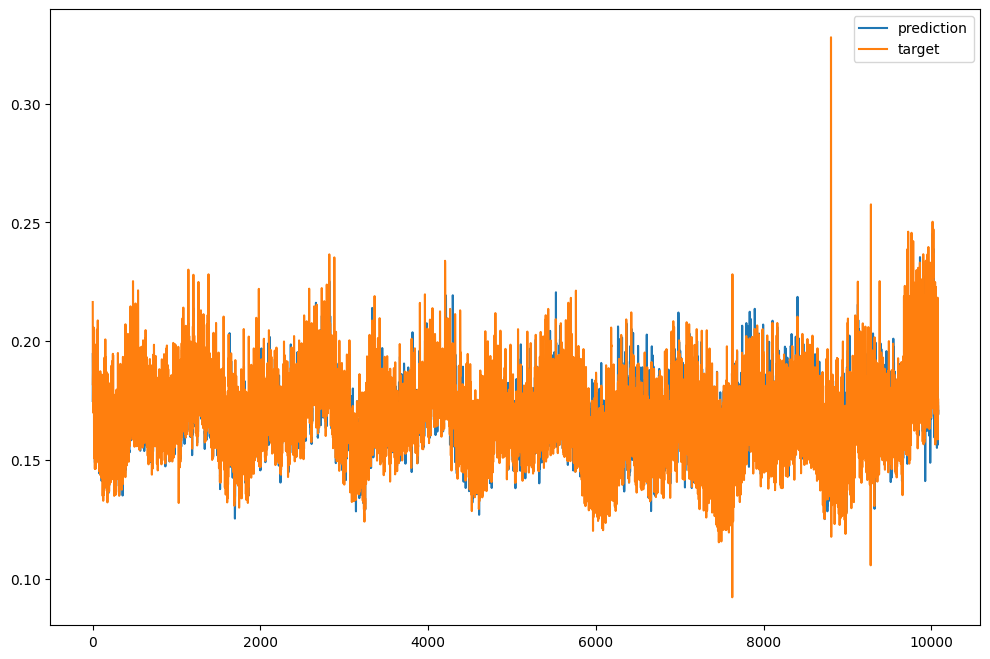

In [70]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

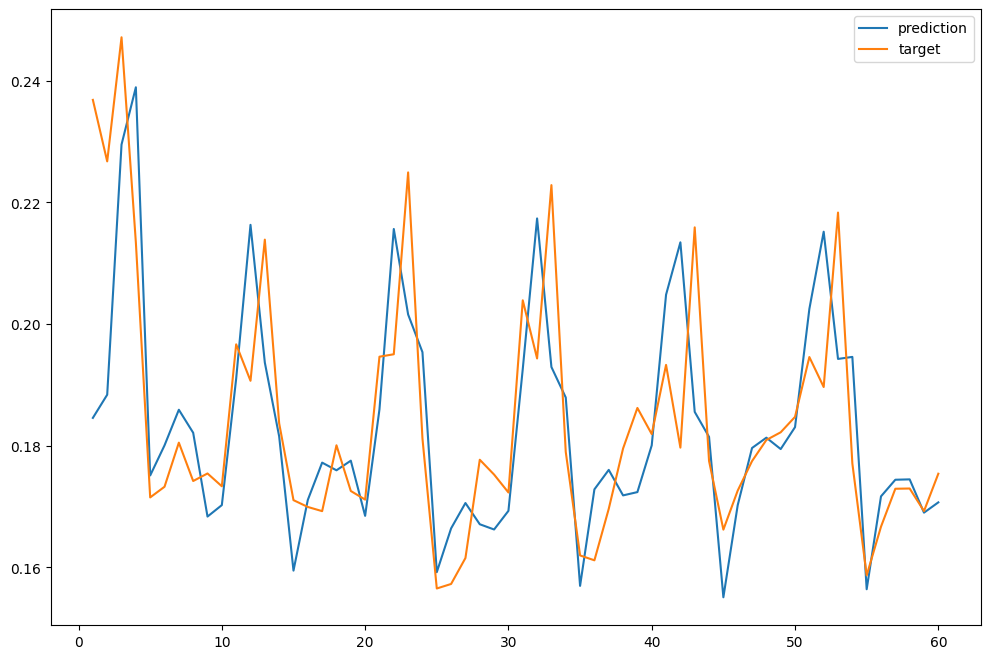

In [71]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [72]:
np.mean(time_list)

0.8192748700579008

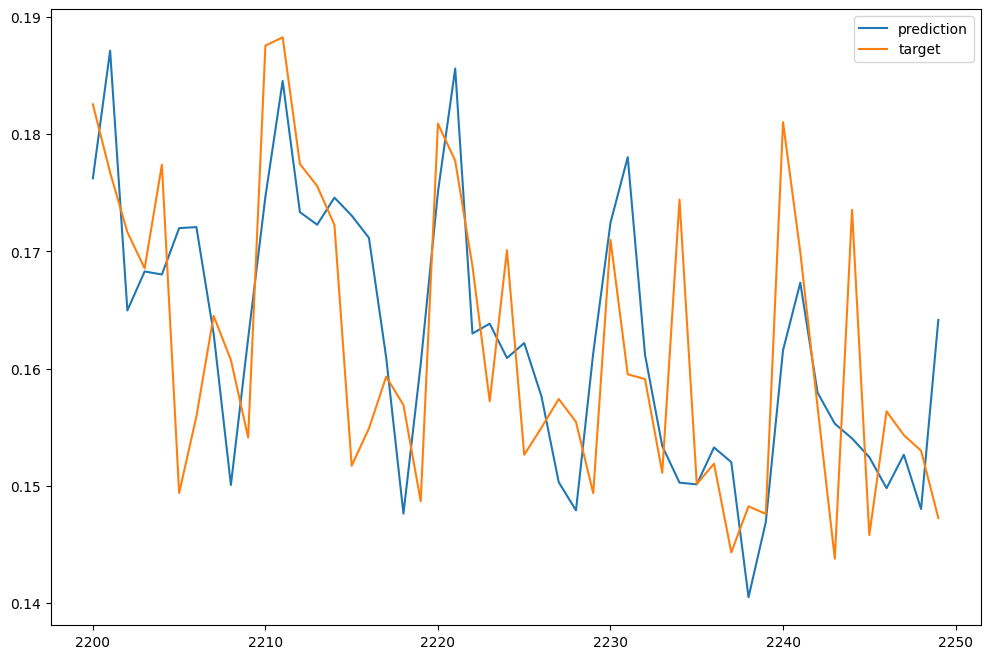

In [73]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()